In [22]:
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [23]:
NYC_PREPARED_DATA_PATH = 'data/NYPD_Shooting_Incident_Data_PREPARE.csv'

## Read data

In [24]:
nyc_df = pd.read_csv(NYC_PREPARED_DATA_PATH)

# DBSCAN from API

In [25]:
missing_values = nyc_df[['latitude', 'longitude']].isnull().sum()
missing_values

latitude     0
longitude    0
dtype: int64

In [26]:
nyc_df = nyc_df.dropna(subset=['longitude', 'latitude'])

In [27]:
# Prepare the clean data for DBSCAN
clean_coords = nyc_df[['latitude', 'longitude']].to_numpy()

In [28]:
clean_coords

array([[ 40.66296462, -73.73083869],
       [ 40.81035186, -73.92494233],
       [ 40.74260663, -73.91549174],
       ...,
       [ 40.81020941, -73.9394955 ],
       [ 40.855644  , -73.896141  ],
       [ 40.837102  , -73.847134  ]])

In [31]:
# Define the range of parameters for the experiment
eps_values = np.arange(0.001, 0.027, 0.005)  # Possible epsilon values
min_samples_values = range(5, 20, 5)  # Possible minimum sample values

In [32]:
eps_values

array([0.001, 0.006, 0.011, 0.016, 0.021, 0.026])

In [35]:
# Variables to store the best parameters and the best silhouette score
best_eps = None
best_min_samples = None
best_silhouette = -1

# Perform grid search
for eps in eps_values:
    for min_samples in min_samples_values:
        # Apply DBSCAN
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(clean_coords)
        if len(set(db.labels_)) > 1:  # Silhouette_score cannot be calculated with a single cluster
            sil_score = silhouette_score(clean_coords, db.labels_)
            # Check if this is the best silhouette score so far
            if sil_score > best_silhouette:
                best_eps = eps
                best_min_samples = min_samples
                best_silhouette = sil_score

(best_eps, best_min_samples, best_silhouette)

(0.026000000000000002, 5, 0.3466068330042389)

In [41]:
# Reinitialize and fit the DBSCAN model with clean data
db_clean = DBSCAN(eps=0.0025, min_samples=15).fit(clean_coords)
# db_clean = DBSCAN(eps=0.026000000000000002, min_samples=5).fit(clean_coords)

# Assign cluster labels to the clean dataframe
nyc_df['cluster'] = db_clean.labels_

# Overview of the cluster distribution in the cleaned data
clean_cluster_distribution = nyc_df['cluster'].value_counts()
clean_cluster_distribution.head()

cluster
 2    8392
 0    5321
-1    3612
 4    2821
 1     681
Name: count, dtype: int64

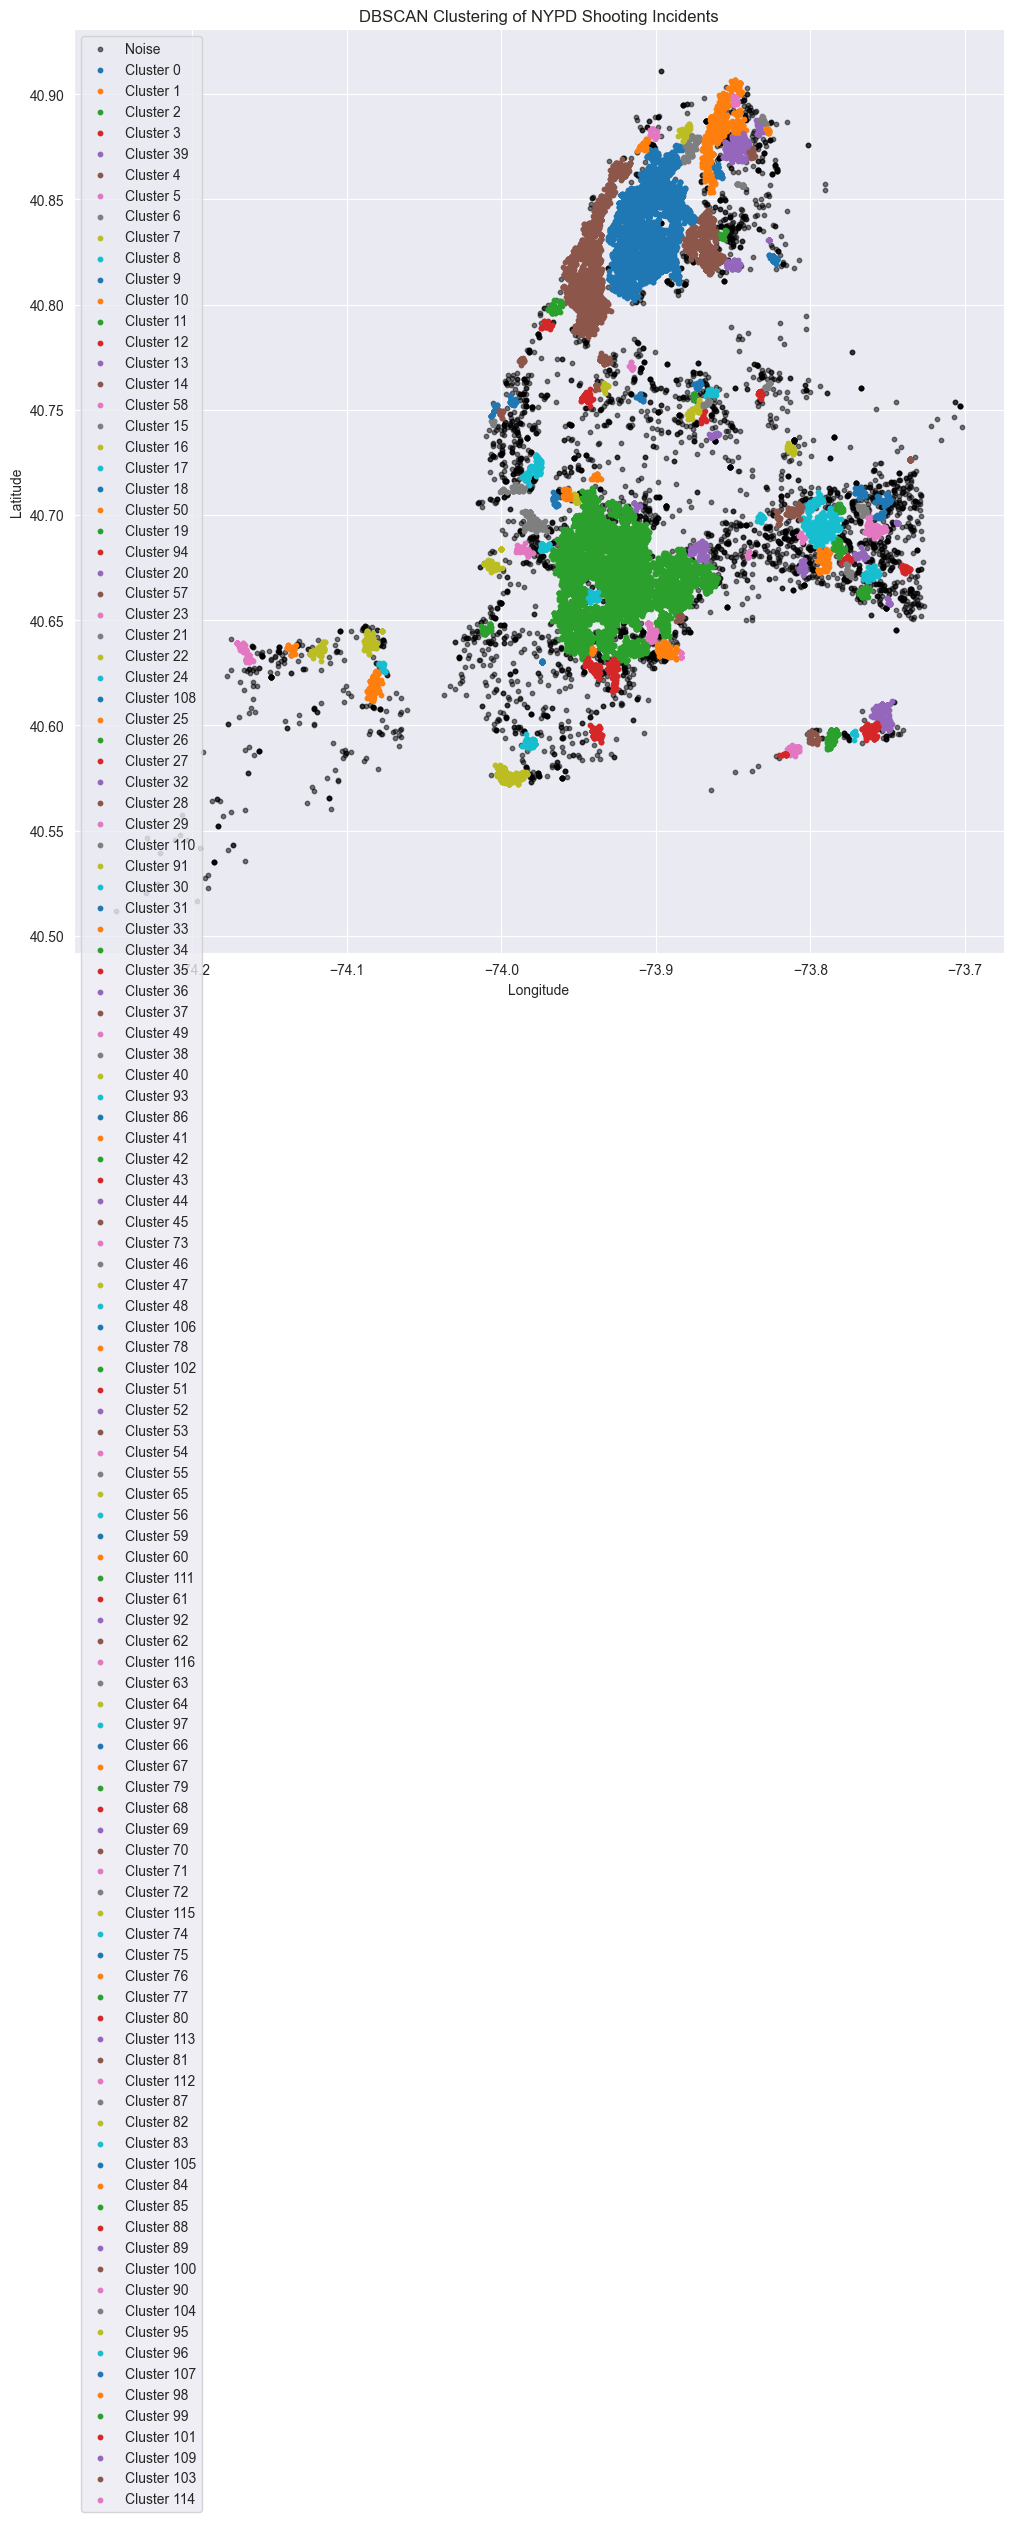

In [42]:
# Set up the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plotting each cluster with a different color
labels = nyc_df['cluster'].unique()
for label in labels:
    cluster_data = nyc_df[nyc_df['cluster'] == label]
    if label == -1:
        # Plot noise points in black
        ax.scatter(cluster_data['longitude'], cluster_data['latitude'], c='k', label=f'Noise', s=10, alpha=0.5)
    else:
        ax.scatter(cluster_data['longitude'], cluster_data['latitude'], label=f'Cluster {label}', s=10)

# Setting up additional parameters for the plot
ax.set_title('DBSCAN Clustering of NYPD Shooting Incidents')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.legend()

# Display the plot
plt.show()